<a href="https://colab.research.google.com/github/etorresram/LPI-Prediction-with-MLModels/blob/main/LPI_Prediction_MLModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Predicting the Logistics Performance Index (LPI) with Tree-Based Machine Learning Methods**
### Author: Eric Torres

#### 📌 Roadmap

**1. Data collection** – Import relevant datasets.  
**2. Data Cleaning** – Standardize variable names, formats, and units.  
**3. Key alignment (pre-merge)** – Align merge keys (e.g., country names, year formats, duplicates) across datasets.  
**4. Merging** – Combine datasets into a single unified dataframe.  
**5. Missing values exploration** – Explore and visualize missing data patterns.  
**6. Modeling** – Predict the logistics performance index using regression models.  
**7. Results** – Evaluate model performance and interpret outputs.

**Note:** The results presented in this Colab notebook may differ in some cases slightly from those shown in the document, as the original results were computed in a VSCode environment. Although the same code and package versions were used, minor discrepancies can arise due to system-level parallelism, floating-point precision, and the way multithreaded models (such as Random Forest or XGBoost) execute across platforms. These differences are minimal—typically in the hundredths place—and do not affect the validity of the findings.

In [ ]:
#%!pip install scikit-learn==1.3.0 xgboost==3.0.0 lightgbm==4.6.0 numpy==1.24.3 pandas==2.0.3 --quiet
#import os
#os.kill(os.getpid(), 9)

###  **1. Data Loading**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
path = 'data'

file_map = {
    'LPI_INDEX.csv': 'lpi',
    'US_ConcentDiversIndices.csv': 'concent_div',
    'US_ContPortThroughput.csv': 'port_throughput',
    'US_FdiFlowsStock.csv': 'fdi',
    'US_GDPTotal.csv': 'gdp',
    'US_GoodsAndServTradeOpennessBpm6.csv': 'openness',
    'US_LSCI.csv': 'lsci',
    'US_PCI.csv': 'pci',
    'US_Tariff_20230704020713.csv': 'tariff',
    'US_TermsOfTrade.csv': 'terms',
    'IncomeRegions.csv': 'regions',
}

for file, abbrev in file_map.items():
    file_path = os.path.join(path, file)
    globals()[abbrev] = pd.read_csv(file_path)

### **2. Data Harmonization**

### 2.1 LPI Score (The World Bank's Logistic Performance Index 2023)

In [4]:
lpi_score = lpi[['Year', 'Country', 'LPI Score']]
lpi_score = lpi_score.rename(columns={'Country': 'Economy Label', 'LPI Score': 'lpi_index'})

### 2.2 Concentration and Diversification Index
##### The product concentration index reflects the extent to which a country's exports or imports are focused on a few products, as opposed to being more evenly distributed across many. The diversification index measures how much a country's export or import structure by product differs from the global average.

In [5]:
concent_diver = concent_div[['Year', 'Economy Label', 'Flow Label', 'Concentration Index', 'Diversification Index']]
concent_diver = concent_diver[concent_diver['Year'] == 2023]

concent_diver = concent_diver.pivot_table(
    index=['Year', 'Economy Label'],
    columns='Flow Label',
    values=['Concentration Index', 'Diversification Index'],
    aggfunc='first'
)
concent_diver.columns = [
    'Concentration Index Exports', 'Concentration Index Imports',
    'Diversification Index Exports', 'Diversification Index Imports'
]

concent_diver = concent_diver.reset_index()
concent_diver = concent_diver.rename(columns={'Concentration Index Exports': 'Concent_Index_Exports',
                                              'Concentration Index Imports': 'Concent_Index_Imports',
                                              'Diversification Index Exports': 'Diver_Index_Exports',
                                              'Diversification Index Imports': 'Diver_Index_Imports'})

### 2.3 Container port throughput, annual
##### This dataframe presents the estimated total number of containers handled per country, measured in twenty-foot equivalent units (TEUs). One TEU corresponds to the volume of a standard 20-foot intermodal container used for loading, unloading, repositioning, and transshipment; a 40-foot container is counted as two TEUs.

In [6]:
throughput = port_throughput.pivot(index='Economy Label',
                                   columns='Year',
                                   values='TEU (Twenty foot Equivalent Unit)')

throughput['containers'] = throughput[2023].fillna(throughput[2022]).fillna(throughput[2019]).fillna(throughput[2018]).fillna(throughput[2017]).fillna(throughput[2016])
throughput['Year'] = 2023
throughput = throughput.reset_index()[['Year', 'Economy Label', 'containers']]
throughput.columns.name = None

### 2.4 Foreign Direct Investment
#### This dataframe provides information on foreign direct investment (FDI) inward and outward flows and stocks, expressed in millions of US dollars.

In [7]:
fdi_flows = fdi[fdi['Year'].isin([2023])]
fdi_flows = fdi_flows.pivot_table(
    index=['Year', 'Economy Label'],
    columns=['Flow Label', 'Direction Label'],
    values='US$ at current prices in millions',
    aggfunc='sum',
)
fdi_flows.columns = [f'{flow} {direction}' for flow, direction in fdi_flows.columns]
fdi_flows = fdi_flows.reset_index()

fdi_flows = fdi_flows.rename(columns={'Flow Inward':   'fdi_flow_inward',
                                              'Flow Outward':  'fdi_flow_outward',
                                              'Stock Inward':  'fdi_stock_inward',
                                              'Stock Outward': 'fdi_stock_outward'})

### 2.5 Gross Domestic Productt
#### This table presents gross domestic product (GDP) in millions of US dollars at constant 2015 prices.

In [8]:
gdp_constant = gdp[['Year', 'Economy Label', 'US$ at constant prices (2015) in millions']]
gdp_constant = gdp_constant[gdp_constant['Year'].isin([2023])]
gdp_constant = gdp_constant.rename(columns={'US$ at constant prices (2015) in millions': 'gdp'})

### 2.6 Openess Economy (trade in goods)
#### This table presents the value of goods exports and imports in US dollars, as well as their share as a percentage of nominal gross domestic product (GDP).

In [9]:
openness_goods = openness[[
    'Year',
    'Series Label',
    'Economy Label',
    'Flow Label',
    'US$ at current prices in millions',
    'Percentage of Gross Domestic Product'
]]

openness_goods = openness_goods.query(
    "`Year`==2023 and `Series Label` == 'Total trade in goods' and `Flow Label` in ['Exports', 'Imports']"
)

openness_goods = openness_goods.pivot_table(
    index=['Year', 'Economy Label'],
    columns='Flow Label',
    values=['US$ at current prices in millions', 'Percentage of Gross Domestic Product'],
    aggfunc='first'
)

openness_goods.columns = [f"{val} {flow}" for val, flow in openness_goods.columns]

openness_goods = openness_goods.rename(columns={
    'US$ at current prices in millions Exports': 'value_export_goods',
    'US$ at current prices in millions Imports': 'value_import_goods',
    'Percentage of Gross Domestic Product Exports': 'percent_export_goods',
    'Percentage of Gross Domestic Product Imports': 'percent_import_goods'
})

openness_goods = openness_goods.reset_index()

### 2.7 Liner shipping connectivity index, quarterly
#### This table shows the Liner Shipping Connectivity Index (LSCI), which measures how well a country is integrated into global shipping networks. Higher values indicate better access to international markets.

In [10]:
lsci['Year'] = lsci['Quarter'].str[:4].astype(int)
lsci_year = lsci.groupby(['Year', 'Economy Label'])['Index (Average Q1 2023 = 100)'].mean().reset_index()
lsci_year = lsci_year.rename(columns={'Index (Average Q1 2023 = 100)': 'lsci_index'})

lsci_year = lsci_year.pivot(index='Economy Label',
                                   columns='Year',
                                   values='lsci_index')


lsci_year['lsci_index'] = lsci_year[2023].fillna(lsci_year[2022]).fillna(lsci_year[2019])

lsci_year['Year'] = 2023
lsci_year = lsci_year.reset_index()[['Year', 'Economy Label', 'lsci_index']]
lsci_year.columns.name = None

### 2.8 Productive Capacity Index
#### The Productive Capacities Index (PCI), developed by UNCTAD, assesses a country’s ability to produce goods and services across eight dimensions: natural capital, human capital, energy, institutions, private sector, structural change, transport, and ICT. This table includes only three components of the PCI: Transport, ICT, and the Overall score.

In [11]:
pcindex = pci.loc[pci['Year'] == 2022, ['Year', 'Economy Label', 'Category Label',
                                         'Productive Capacities Index']]
pcindex = (
    pcindex
    .query(
        "`Year` == 2022 and `Category Label` in ["
        "'Overall index: Productive capacities index', "
        "'Transport', "
        "'Information and Communication Technology (ICT)']"
    )[['Year', 'Economy Label', 'Category Label', 'Productive Capacities Index']]
    .pivot_table(
        index=['Year', 'Economy Label'],
        columns='Category Label',
        values='Productive Capacities Index',
        aggfunc='first'
    )
    .rename(columns={
        'Overall index: Productive capacities index': 'pci_overall',
        'Transport': 'pci_transport',
        'Information and Communication Technology (ICT)': 'pci_ict',
    })
    .reset_index()
)
pcindex["Year"] = 2023

### 2.9 Import tariff rates on non-agricultural and non-fuel products, annual
#### This table presents (Effectively applied import tariff rates) for major categories of non-agricultural and non-fuel products, disaggregated by individual countries.

In [12]:
tariff_goods = tariff.query(
    "((Year == 2021) or (`Market Label` == 'Bahamas' and Year == 2018)) and "
    "`DutyType Label` == 'Effectively applied rate' and "
    "`Origin Label` == 'World' and "
    "`ProductCategory Label` == 'Manufactured goods' and "
    "`Indicator Label` == 'Simple average'"
)

tariff_goods = tariff_goods[[
    'Year',
    'Market Label',
    'Absolute value'
]]

tariff_goods = tariff_goods.rename(columns={
    'Market Label': 'Economy Label',
    'Absolute value': 'tariff_goods'
})

# Asigna el año 2023 a todas las filas (se puede hacer esto si se quiere unificar la referencia temporal)
tariff_goods["Year"] = 2023
tariff_goods = tariff_goods.drop_duplicates()
tariff_goods["Economy Label"] = tariff_goods["Economy Label"].replace("Türkiye", "Turkey")


### 2.10 Merchandise: Trade value, volume, unit value, terms of trade indices and purchasing power index of exports, annual
#### This dataset includes the export and import volume indices referenced to the base year 2015. These indices measure the physical volume of trade, excluding price effects.

In [13]:
index_volume = terms[['Year', 'Economy Label', 'Index Label', 'Index Base 2015']]

index_volume = index_volume.query(
    "`Year` == 2023 and `Index Label` in ['Volume index of exports', 'Volume index of imports']"
)

index_volume = index_volume.pivot_table(
    index=['Year', 'Economy Label'],
    columns='Index Label',
    values=['Index Base 2015'],
    aggfunc='first'
)

index_volume.columns = [f"{val} {flow}" for val, flow in index_volume.columns]

index_volume = index_volume.rename(columns={
    'Index Base 2015 Volume index of exports': 'Index_volume_exports',
    'Index Base 2015 Volume index of imports': 'Index_volume_imports',
})

index_volume = index_volume.reset_index()

### **3. Pre-merge checks**

In [14]:
# Harmonizing country names across all CSVs

lpi_score["Economy Label"] = lpi_score["Economy Label"].replace("Bahamas, The", "Bahamas")

pcindex["Economy Label"] = pcindex["Economy Label"].replace("United States of America", "United States")
pcindex["Economy Label"] = pcindex["Economy Label"].replace("Moldova, Republic of", "Republic of Moldova")
pcindex["Economy Label"] = pcindex["Economy Label"].replace("Korea, Republic of", "Republic of Korea")
pcindex["Economy Label"] = pcindex["Economy Label"].replace("Congo, Dem. Rep. of the", "Dem. Rep. of the Congo")
pcindex["Economy Label"] = pcindex["Economy Label"].replace("Switzerland, Liechtenstein", "Switzerland")
pcindex["Economy Label"] = pcindex["Economy Label"].replace("Tanzania, United Republic of", "United Republic of Tanzania")

tariff_goods["Economy Label"] = tariff_goods["Economy Label"].replace("United States of America", "United States")
tariff_goods["Economy Label"] = tariff_goods["Economy Label"].replace("Moldova, Republic of", "Republic of Moldova")
tariff_goods["Economy Label"] = tariff_goods["Economy Label"].replace("Turkey", "Turkiye")
tariff_goods["Economy Label"] = tariff_goods["Economy Label"].replace("Korea, Republic of", "Republic of Korea")
tariff_goods["Economy Label"] = tariff_goods["Economy Label"].replace("Switzerland, Liechtenstein", "Switzerland")
tariff_goods["Economy Label"] = tariff_goods["Economy Label"].replace("Tanzania, United Republic of", "United Republic of Tanzania")

In [15]:
# Check for duplicates in each dataframe
dataframes = {
    "lpi_score": lpi_score,
    "concent_diver": concent_diver,
    "throughput": throughput,
    "fdi_flows": fdi_flows,
    "gdp_constant": gdp_constant,
    "openness_goods": openness_goods,
    "lsci_year": lsci_year,
    "pcindex": pcindex,
    "tariff_goods": tariff_goods,
    "index_volume": index_volume
}

for name, df in dataframes.items():
    duplicates = df.duplicated()
    num_duplicates = duplicates.sum()
    print(f"{name}: {num_duplicates} duplicated rows")

    # If duplicates exist, print the repeated rows
    if num_duplicates > 0:
              print(df[duplicates])

lpi_score: 0 duplicated rows
concent_diver: 0 duplicated rows
throughput: 0 duplicated rows
fdi_flows: 0 duplicated rows
gdp_constant: 0 duplicated rows
openness_goods: 0 duplicated rows
lsci_year: 0 duplicated rows
pcindex: 0 duplicated rows
tariff_goods: 0 duplicated rows
index_volume: 0 duplicated rows


In [16]:
# rows per dataframe
for name, df in dataframes.items():
    print(f"{name}: {len(df)} rows")

lpi_score: 139 rows
concent_diver: 282 rows
throughput: 199 rows
fdi_flows: 281 rows
gdp_constant: 294 rows
openness_goods: 267 rows
lsci_year: 191 rows
pcindex: 257 rows
tariff_goods: 168 rows
index_volume: 279 rows


### **4. Merging Process**
**df_merged_total** = Raw dataset before filtering countries I need.  
**df_merged_lpi** = Dataset that contains only countries with an official LPI published by the World Bank.  
**df_to_predict** = Dataset with 13 countries that do not have an official LPI and for which the index will be predicted.


In [40]:
from functools import reduce

# df_merged_total
dfs = [lpi_score, concent_diver, throughput, fdi_flows, gdp_constant,
       openness_goods, lsci_year, pcindex, tariff_goods, index_volume]
df_merged_total = reduce(lambda left, right: pd.merge(left, right, on=["Economy Label", "Year"], how="outer"), dfs)



# df_merged_lpi
#df_merged_139=df_merged_total.head(139)
df_merged_139 = df_merged_total[df_merged_total['lpi_index'] > 0]

df_merged_lpi = pd.merge(df_merged_139, regions, on=['Year', 'Economy Label'], how='left')
new_cols = [col for col in regions.columns if col not in ['Year', 'Economy Label']]
cols = list(df_merged_lpi.columns)
idx = cols.index('Economy Label')
ordered_cols = cols[:idx+1] + new_cols + [col for col in cols if col not in new_cols and col not in cols[:idx+1]]
df_merged_lpi = df_merged_lpi[ordered_cols]

selected_countries = [
    "Azerbaijan", "Barbados", "Belize", "Ecuador", "Jordan",
    "Kenya", "Lebanon", "Morocco", "Mozambique", "Pakistan",
    "Senegal", "Suriname", "Tunisia"
]

# df_to predict
df_to_predict = df_merged_total.loc[df_merged_total["Economy Label"].isin(selected_countries), df_merged_total.columns[:139]]

df_to_predict = df_to_predict.merge(
    regions[['Economy Label', 'Region', 'Income_group']],
    on='Economy Label',
    how='left'
)


### **5. Missing Data Analysis**

### 5.1 Total percentage of missings

In [18]:
excluded_columns = ['Year', 'Economy Label', 'Region', 'Income_group', 'lpi_index']

predictor_df = df_merged_lpi.drop(columns=excluded_columns)
total_missing = predictor_df.isna().sum().sum()
total_values = predictor_df.shape[0] * predictor_df.shape[1]
missing_percentage_total = (total_missing / total_values) * 100

print(f"\nTotal percentage of missing values (excluding target and non-predictive columns): {missing_percentage_total:.1f}%")


Total percentage of missing values (excluding target and non-predictive columns): 5.9%


### 5.2 Missings by variable

In [19]:
cols = [
    "Concent_Index_Exports", "Concent_Index_Imports", "Diver_Index_Exports", "Diver_Index_Imports",
    "containers", "fdi_flow_inward", "fdi_flow_outward", "fdi_stock_inward", "fdi_stock_outward", "gdp",
    "percent_export_goods", "percent_import_goods", "value_export_goods", "value_import_goods",
    "lsci_index", "pci_ict", "pci_overall", "pci_transport", "tariff_goods",
    "Index_volume_exports", "Index_volume_imports"
]

nan_counts = df_merged_lpi[cols].isna().sum()
missing_percent = df_merged_lpi[cols].isna().mean() * 100

missing_summary = pd.DataFrame({
    'Count': nan_counts,
    'Percentage': missing_percent
})

missing_summary = missing_summary.sort_values(by='Count', ascending=False)
missing_summary

,Count,Percentage
containers,39,28.057554
lsci_index,26,18.705036
tariff_goods,20,14.388489
percent_export_goods,12,8.633094
percent_import_goods,12,8.633094
fdi_flow_outward,12,8.633094
value_import_goods,11,7.913669
value_export_goods,11,7.913669
fdi_stock_outward,8,5.755396
fdi_flow_inward,5,3.597122


### 5.3 Missings visualization

<ipython-input-20-2e141a2e01e5>:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x500 with 0 Axes>

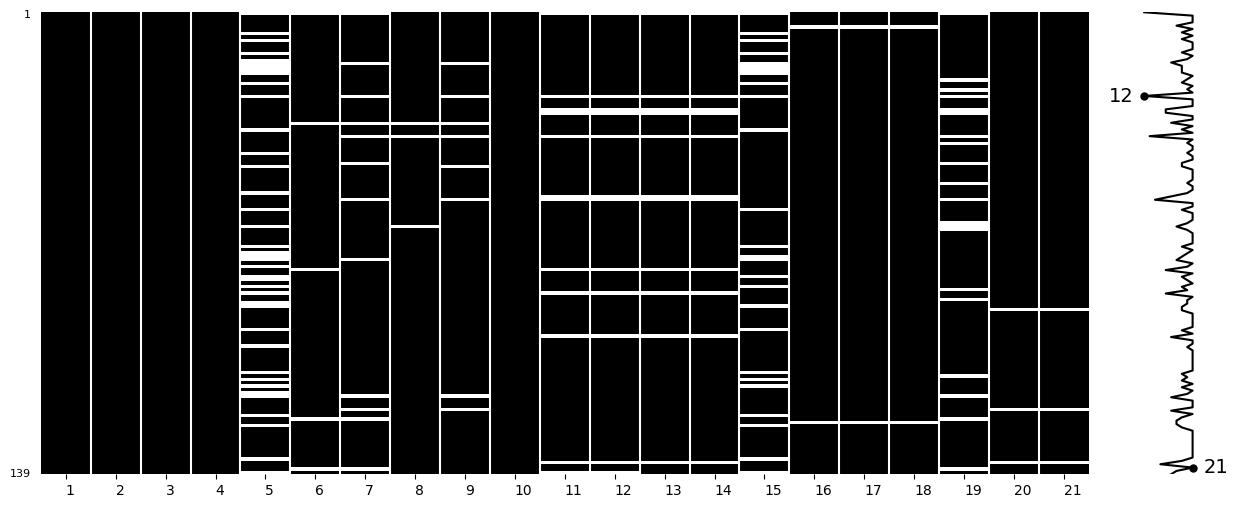

In [20]:
import missingno as msno

df_plot = df_merged_lpi.drop(columns=['Year', 'Economy Label', 'Region', 'Income_group', 'lpi_index'])

fig = plt.figure(figsize=(12, 5))
msno.matrix(df_plot, figsize=(15, 6), sparkline=True, color=(0, 0, 0))
ax = plt.gca()
ax.xaxis.tick_bottom()

num_columns = df_plot.shape[1]
xtick_positions = np.arange(num_columns)
xtick_labels = [str(i+1) for i in xtick_positions]
plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=0, fontsize=10)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

### 5.4 Missings by region

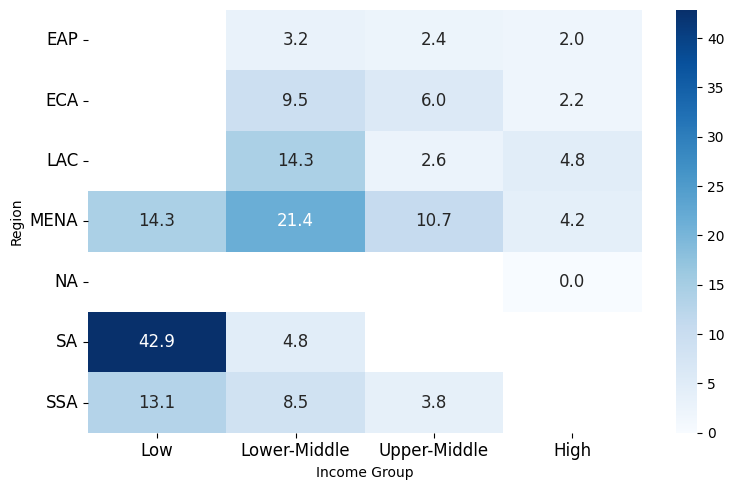

In [21]:
region_abbr = {
    "East Asia & Pacific": "EAP", "Europe & Central Asia": "ECA", "Latin America & Caribbean": "LAC",
    "Middle East & North Africa": "MENA", "North America": "NA", "South Asia": "SA", "Sub-Saharan Africa": "SSA"
}

income_abbr = {
    "Low income": "Low", "Lower middle income": "Lower-Middle", "Upper middle income": "Upper-Middle", "High income": "High"
}

cols_exclude = ['Year', 'Economy Label', 'Region', 'Income_group', 'lpi_index']

df_temp = df_merged_lpi.copy()
df_temp['missing_pct'] = df_temp.drop(columns=cols_exclude).isnull().mean(axis=1) * 100
df_temp['Region_abbr'] = df_temp['Region'].map(region_abbr)
df_temp['Income_abbr'] = df_temp['Income_group'].map(income_abbr)

heatmap_data = df_temp.groupby(['Region_abbr', 'Income_abbr'])['missing_pct'].mean().reset_index()
heatmap_matrix = heatmap_data.pivot(index='Region_abbr', columns='Income_abbr', values='missing_pct')

region_order = ["EAP", "ECA", "LAC", "MENA", "NA", "SA", "SSA"]
income_order = ["Low", "Lower-Middle", "Upper-Middle", "High"]
heatmap_matrix = heatmap_matrix.reindex(index=region_order, columns=income_order)

plt.figure(figsize=(8, 5))
sns.heatmap(
    heatmap_matrix,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar_kws={'label': ''},
    linewidths=0.3,
    linecolor='none',
    annot_kws={"fontsize": 12}
)

plt.xlabel("Income Group")
plt.ylabel("Region")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

### **6. Correlation Analysis**

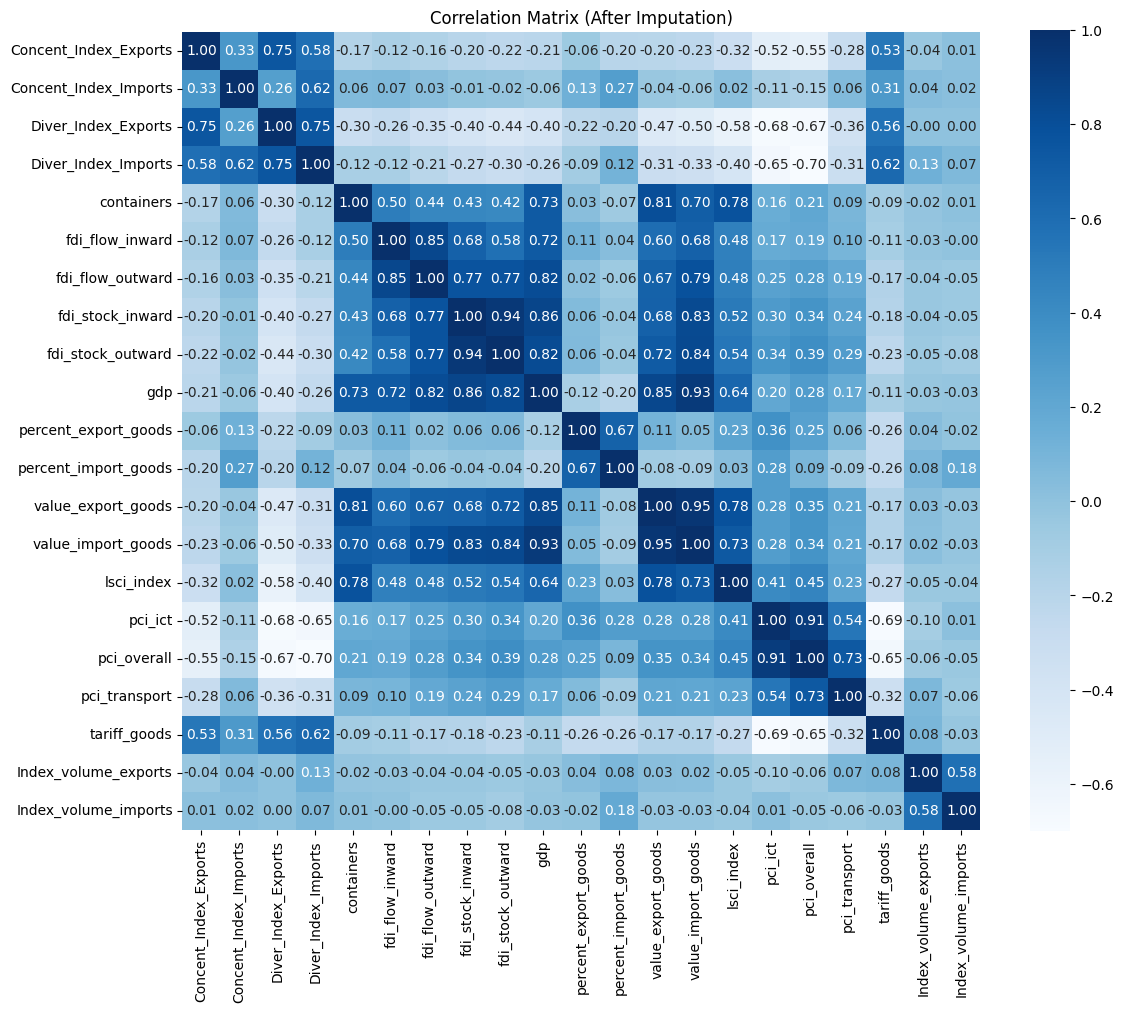

In [22]:


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

excluded_columns = ['Year', 'Economy Label', 'Region', 'Income_group', 'lpi_index']
predictor_df = df_merged_lpi.drop(columns=excluded_columns)

#Imputation using IterativeImputer with RandomForest
imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=42),
                           max_iter=10, random_state=42)

imputed_array = imputer.fit_transform(predictor_df)
imputed_df = pd.DataFrame(imputed_array, columns=predictor_df.columns)

plt.figure(figsize=(12, 10))
sns.heatmap(imputed_df.corr(), annot=True, cmap="Blues", fmt=".2f", square=True,     annot_kws={"size": 10})
plt.title("Correlation Matrix (After Imputation)")
plt.tight_layout()
plt.show()



### **6. Modelling Only Numerical Features**

### 6.1 Results with default parameters

In [23]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline



models = {}

# Models
try:
    from xgboost import XGBRegressor
    models["XGBoost"] = XGBRegressor(random_state=42)
except ImportError:
    print("XGBoost is not installed. You can install it with: pip install xgboost")

try:
    from lightgbm import LGBMRegressor
    models["LightGBM"] = LGBMRegressor(random_state=42)
except ImportError:
    print("LightGBM is not installed. You can install it with: pip install lightgbm")

models.update({
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "KNN Regressor": KNeighborsRegressor(),
    "Support Vector Regressor": SVR(),
    "Ridge": Ridge(),
    "Bayesian Ridge": BayesianRidge(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
})

# 1. Feature and target selection
features = [col for col in df_merged_lpi.columns if col not in ['Economy Label', 'Year', 'Region', 'Income_group', 'lpi_index']]
target = 'lpi_index'

# 2. Train-test split
df_train, df_test = train_test_split(df_merged_lpi, test_size=0.2, random_state=42)
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

# 3. Missing value imputation
imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), max_iter=10, random_state=42)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 4. Robust normalization (robust to outliers and non-normal distributions)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# 5. Training and evaluation
results = []

for name, model in models.items():
    try:
        model.fit(X_train_scaled, y_train)

        y_pred_train = model.predict(X_train_scaled)
        r2_train = r2_score(y_train, y_pred_train)

        y_pred_test = model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred_test)  # Calcular MAE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        r2_test = r2_score(y_test, y_pred_test)
        corr = np.corrcoef(y_test, y_pred_test)[0, 1]

        results.append({
            "Model": name,
            "Train R²": round(r2_train, 3),
            "Test R²": round(r2_test, 3),
            "MAE": round(mae, 3),  # Nueva columna MAE
            "RMSE": round(rmse, 3),
            "Correlation": round(corr, 3)
        })

    except Exception as e:
        print(f"Error training {name}: {e}")

# 6. Comparative results (order by Test R²)
df_results = pd.DataFrame(results).sort_values(by="Test R²", ascending=False)
df_results = df_results[["Model", "Train R²", "Test R²", "MAE", "RMSE", "Correlation"]]

# 7. Save predictions from the best model
best_model = df_results.iloc[0]["Model"]
final_model = models[best_model]
y_pred_final = final_model.predict(X_test_scaled)

df_test = df_test.copy()
df_test['lpi_index_pred'] = np.round(y_pred_final, 1)

df_results

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 111, number of used features: 21
[LightGBM] [Info] Start training from score 2.987387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

,Model,Train R²,Test R²,MAE,RMSE,Correlation
10,Extra Trees,1.000,0.857,0.180,0.221,0.940
1,LightGBM,0.967,0.856,0.182,0.222,0.932
2,Random Forest,0.972,0.842,0.192,0.233,0.922
3,Gradient Boosting,0.996,0.831,0.194,0.241,0.919
0,XGBoost,1.000,0.806,0.220,0.258,0.911
5,KNN Regressor,0.812,0.759,0.241,0.288,0.881
6,Support Vector Regressor,0.773,0.727,0.258,0.306,0.863
9,Decision Tree,1.000,0.695,0.261,0.323,0.834
4,Linear Regression,0.833,0.392,0.282,0.457,0.763
7,Ridge,0.832,0.316,0.300,0.485,0.756


### 6.2 GridSearch

In [27]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

param_grid_lgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 5, 8, 10],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [15, 31],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}

grid_lgb = GridSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_grid=param_grid_lgb,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_lgb.fit(X_train_imputed, y_train)
print("Best LightGBM params:", grid_lgb.best_params_)


from sklearn.ensemble import ExtraTreesRegressor
param_grid_et = {
    'n_estimators': [100, 200, 300],
    'max_depth': [ 4, 5, 8, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_et = GridSearchCV(
    ExtraTreesRegressor(random_state=42),
    param_grid=param_grid_et,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

grid_et.fit(X_train_scaled, y_train)
print("Best Extra Trees params:", grid_et.best_params_)


from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [ 4, 5, 8, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train_scaled, y_train)
print("Best Random Forest params:", grid_rf.best_params_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 798
[LightGBM] [Info] Number of data points in the train set: 111, number of used features: 21
[LightGBM] [Info] Start training from score 2.987387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

### 6.3 Optimized Baseline Results

In [24]:

models = {}


try:
    from lightgbm import LGBMRegressor
    models["LightGBM"] = LGBMRegressor(
        colsample_bytree= 0.6,
        learning_rate=0.05,
        max_depth=4,
        n_estimators=100,
        num_leaves=15,
        random_state=42,
        subsample=0.6
    )
except ImportError:
    print("LightGBM is not installed. You can install it with: pip install lightgbm")

models["Extra Trees"] = ExtraTreesRegressor(
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)

models["Random Forest"] = RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)

# 1. Feature and target selection
features = [col for col in df_merged_lpi.columns if col not in ['Economy Label', 'Year', 'Region', 'Income_group', 'lpi_index']]
target = 'lpi_index'

# 2. Train-test split
df_train, df_test = train_test_split(df_merged_lpi, test_size=0.2, random_state=42)
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

# 3. Missing value imputation
imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), max_iter=10, random_state=42)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 4. Robust normalization
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# 5. Training and evaluation
results = []

for name, model in models.items():
    try:
        model.fit(X_train_scaled, y_train)

        y_pred_train = model.predict(X_train_scaled)
        r2_train = r2_score(y_train, y_pred_train)

        y_pred_test = model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        r2_test = r2_score(y_test, y_pred_test)
        corr = np.corrcoef(y_test, y_pred_test)[0, 1]

        results.append({
            "Model": name,
            "Train R²": round(r2_train, 3),
            "Test R²": round(r2_test, 3),
            "MAE": round(mae, 3),
            "RMSE": round(rmse, 3),
            "Correlation": round(corr, 3)
        })

    except Exception as e:
        print(f"Error training {name}: {e}")

# 6. Comparative results
df_results = pd.DataFrame(results).sort_values(by="Test R²", ascending=False)

# 7. Save predictions from the best model
best_model = df_results.iloc[0]["Model"]
final_model = models[best_model]
y_pred_final = final_model.predict(X_test_scaled)

# 8. Add prediction results to df_test
df_test = df_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

df_test['lpi_index_actual'] = y_test
df_test['lpi_index_pred'] = y_pred_final
df_test['residual'] = df_test['lpi_index_pred'] - df_test['lpi_index_actual']
df_test['lpi_index_pred'] = np.round(df_test['lpi_index_pred'], 1)

df_results

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 111, number of used features: 21
[LightGBM] [Info] Start training from score 2.987387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

,Model,Train R²,Test R²,MAE,RMSE,Correlation
1,Extra Trees,0.992,0.855,0.183,0.223,0.937
0,LightGBM,0.928,0.849,0.191,0.228,0.927
2,Random Forest,0.963,0.837,0.195,0.237,0.920


### 6.4 Cross-Validation

In [25]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

neg_rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
neg_mae = make_scorer(mean_absolute_error, greater_is_better=False)


cv_results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("imputer", IterativeImputer(estimator=RandomForestRegressor(random_state=42), max_iter=10, random_state=42)),
        ("scaler", RobustScaler()),
        ("regressor", model)
    ])

    scores = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring={'r2': 'r2', 'rmse': neg_rmse, 'mae': neg_mae},
        return_train_score=True
    )

    cv_results[name] = {
        'Train R² (mean)': round(np.mean(scores['train_r2']), 3),
        'Test R² (mean)': round(np.mean(scores['test_r2']), 3),
        'Test MAE (mean)': round(-np.mean(scores['test_mae']), 3),
        'Test RMSE (mean)': round(-np.mean(scores['test_rmse']), 3)
    }


df_cv = pd.DataFrame(cv_results).T.sort_values(by="Test R² (mean)", ascending=False)
display(df_cv)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 21
[LightGBM] [Info] Start training from score 2.996591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

,Train R² (mean),Test R² (mean),Test MAE (mean),Test RMSE (mean)
Extra Trees,0.991,0.770,0.217,0.273
Random Forest,0.959,0.767,0.215,0.275
LightGBM,0.912,0.747,0.220,0.285


### 6.5 Residuals

<ipython-input-26-dc79db51737d>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='residual', y='Income_abbr', data=df_plot,
<ipython-input-26-dc79db51737d>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='residual', y='Region_abbr', data=df_plot,


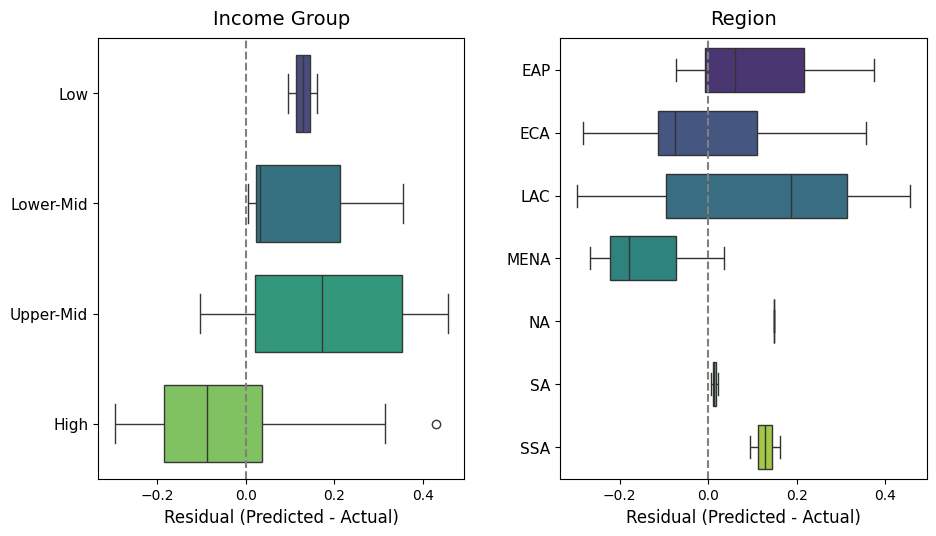

In [26]:
region_abbr = {
    "East Asia & Pacific": "EAP",
    "Europe & Central Asia": "ECA",
    "Latin America & Caribbean": "LAC",
    "Middle East & North Africa": "MENA",
    "North America": "NA",
    "South Asia": "SA",
    "Sub-Saharan Africa": "SSA"
}

income_abbr = {
    "Low income": "Low",
    "Lower middle income": "Lower-Mid",
    "Upper middle income": "Upper-Mid",
    "High income": "High"
}

df_plot = df_test.copy()
df_plot['Region_abbr'] = df_plot['Region'].map(region_abbr)
df_plot['Income_abbr'] = df_plot['Income_group'].map(income_abbr)

income_order = ["Low", "Lower-Mid", "Upper-Mid", "High"]
region_order = ["EAP", "ECA", "LAC", "MENA", "NA", "SA", "SSA"]



plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='residual', y='Income_abbr', data=df_plot,
            order=income_order,
            palette="viridis",
            orient='h',
            width=0.7)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Income Group", fontsize=14, pad=10, fontweight='normal')
plt.xlabel("Residual (Predicted - Actual)", fontsize=12)
plt.ylabel("")
plt.yticks(fontsize=11)

plt.subplot(1, 2, 2)
sns.boxplot(x='residual', y='Region_abbr', data=df_plot,
            order=region_order,
            palette="viridis",
            orient='h',
            width=0.7)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Region", fontsize=14, pad=10, fontweight='normal')
plt.xlabel("Residual (Predicted - Actual)", fontsize=12)
plt.ylabel("")
plt.yticks(fontsize=11)
plt.tight_layout(pad=3.0)
plt.show()

### 6.6 Feature Importance

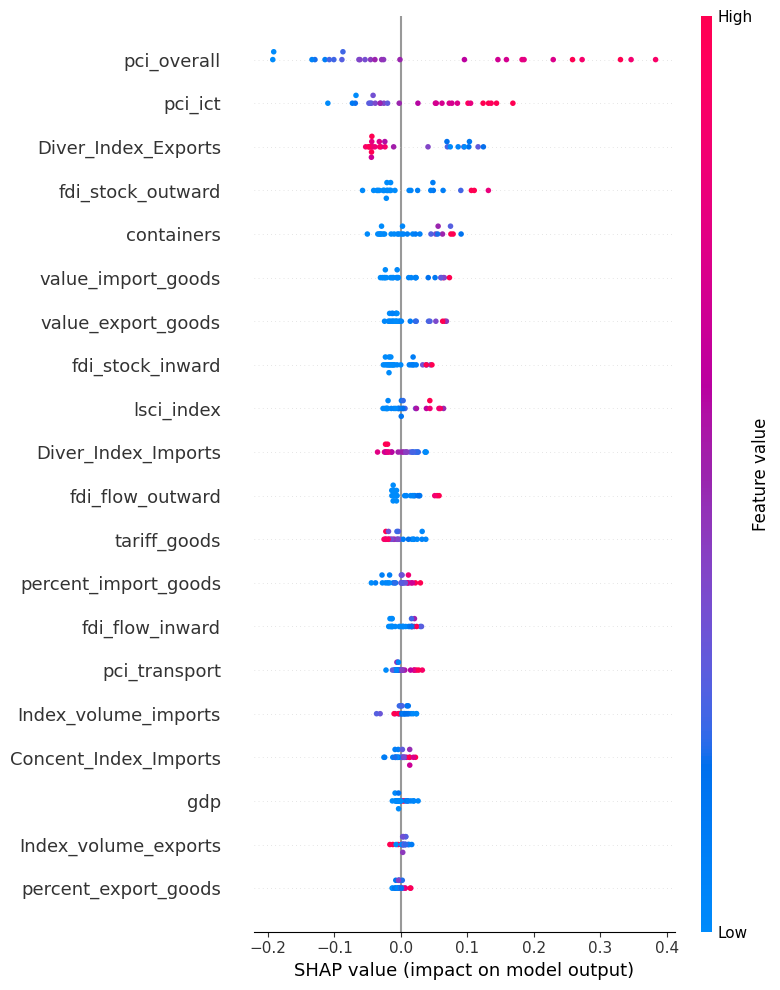

In [27]:
import shap

explainer = shap.Explainer(final_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(
    shap_values,
    features=X_test_scaled,
    feature_names=features,
    max_display=20,
    plot_size=(8, 10),
    show=True
)

### **7. Modelling Including Income groups and Regions as Predictors**

### 7.1 Results with default parameters

In [28]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

models = {}
try:
    from xgboost import XGBRegressor
    models["XGBoost"] = XGBRegressor(random_state=42)
except ImportError:
    print("XGBoost not installed")

try:
    from lightgbm import LGBMRegressor
    models["LightGBM"] = LGBMRegressor(random_state=42)
except ImportError:
    print("LightGBM not installed")

models.update({
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "KNN Regressor": KNeighborsRegressor(),
    "Support Vector Regressor": SVR(),
    "Ridge": Ridge(),
    "Bayesian Ridge": BayesianRidge(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
})


df_train, df_test = train_test_split(df_merged_lpi, test_size=0.2, random_state=42)
target = 'lpi_index'


numeric_features = [col for col in df_merged_lpi.columns if col not in ['Economy Label', 'Year', 'Region', 'Income_group', 'lpi_index']]
categorical_features = ['Region', 'Income_group']
features = numeric_features + categorical_features

X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

numeric_transformer = Pipeline([
    ("imputer", IterativeImputer(estimator=RandomForestRegressor(random_state=42), max_iter=10, random_state=42)),
    ("scaler", RobustScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

results = []
for name, model in models.items():
    try:
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model)
        ])
        pipe.fit(X_train, y_train)

        y_pred_train = pipe.predict(X_train)
        y_pred_test = pipe.predict(X_test)

        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        mae = mean_absolute_error(y_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        corr = np.corrcoef(y_test, y_pred_test)[0, 1]

        results.append({
            "Model": name,
            "Train R²": round(r2_train, 3),
            "Test R²": round(r2_test, 3),
            "MAE": round(mae, 3),
            "RMSE": round(rmse, 3),
            "Correlation": round(corr, 3)
        })

    except Exception as e:
        print(f"Error training {name}: {e}")

df_results = pd.DataFrame(results).sort_values(by="Test R²", ascending=False)
df_results

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 111, number of used features: 26
[LightGBM] [Info] Start training from score 2.987387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

,Model,Train R²,Test R²,MAE,RMSE,Correlation
10,Extra Trees,1.000,0.883,0.163,0.201,0.952
1,LightGBM,0.970,0.856,0.182,0.222,0.933
2,Random Forest,0.971,0.843,0.193,0.232,0.923
3,Gradient Boosting,0.997,0.836,0.192,0.237,0.920
0,XGBoost,1.000,0.807,0.212,0.257,0.913
5,KNN Regressor,0.846,0.771,0.231,0.280,0.886
6,Support Vector Regressor,0.797,0.765,0.244,0.284,0.891
9,Decision Tree,1.000,0.763,0.229,0.285,0.882
8,Bayesian Ridge,0.852,-0.186,0.327,0.638,0.713
7,Ridge,0.867,-0.591,0.335,0.739,0.678


### 7.2 GridSearch

In [ ]:
# LightGBM
param_grid_lgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [4, 5, 8, 10],
    'model__learning_rate': [0.05, 0.1],
    'model__num_leaves': [15, 31],
    'model__subsample': [0.6, 0.8],
    'model__colsample_bytree': [0.6, 0.8]
}

pipe_lgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=42))
])

grid_lgb = GridSearchCV(
    estimator=pipe_lgb,
    param_grid=param_grid_lgb,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_lgb.fit(X_train, y_train)

# Extra Trees
param_grid_et = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [2, 3, 4],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

pipe_et = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ExtraTreesRegressor(random_state=42))
])

grid_et = GridSearchCV(
    estimator=pipe_et,
    param_grid=param_grid_et,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_et.fit(X_train, y_train)

# Random Forest
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 4, 5, 8, 10],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

df_best_params = pd.DataFrame([
    {"Model": "LightGBM", **grid_lgb.best_params_},
    {"Model": "Extra Trees", **grid_et.best_params_},
    {"Model": "Random Forest", **grid_rf.best_params_},
])

df_best_params


### 7.3 Optimized Results

In [29]:
models = {
    "LightGBM": LGBMRegressor(
        random_state=42,
        colsample_bytree=0.8,
        learning_rate=0.1,
        max_depth=4,
        n_estimators=100,
        num_leaves=15,
        subsample=0.6
    ),
    "Extra Trees": ExtraTreesRegressor(
        random_state=42,
        max_depth=4,
        min_samples_leaf=2,
        min_samples_split=5,
        n_estimators=300
    ),
    "Random Forest": RandomForestRegressor(
        random_state=42,
        max_depth=4,
        min_samples_leaf=1,
        min_samples_split=5,
        n_estimators=200
    )
}

# Split
df_train, df_test = train_test_split(df_merged_lpi, test_size=0.2, random_state=42)
target = 'lpi_index'

# Variables
numeric_features = [col for col in df_merged_lpi.columns if col not in ['Economy Label', 'Year', 'Region', 'Income_group', 'lpi_index']]
categorical_features = ['Region', 'Income_group']
features = numeric_features + categorical_features

X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

# Pipelines de preprocesamiento
numeric_transformer = Pipeline([
    ("imputer", IterativeImputer(estimator=RandomForestRegressor(random_state=42), max_iter=10, random_state=42)),
    ("scaler", RobustScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# Evaluación
results = []
for name, model in models.items():
    try:
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model)
        ])
        pipe.fit(X_train, y_train)

        y_pred_train = pipe.predict(X_train)
        y_pred_test = pipe.predict(X_test)

        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        mae = mean_absolute_error(y_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        corr = np.corrcoef(y_test, y_pred_test)[0, 1]

        results.append({
            "Model": name,
            "Train R²": round(r2_train, 3),
            "Test R²": round(r2_test, 3),
            "MAE": round(mae, 3),
            "RMSE": round(rmse, 3),
            "Correlation": round(corr, 3)
        })

    except Exception as e:
        print(f"Error training {name}: {e}")

# Resultados finales
df_results = pd.DataFrame(results).sort_values(by="Test R²", ascending=False)
df_results



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 111, number of used features: 26
[LightGBM] [Info] Start training from score 2.987387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

,Model,Train R²,Test R²,MAE,RMSE,Correlation
1,Extra Trees,0.896,0.889,0.144,0.195,0.955
2,Random Forest,0.933,0.848,0.189,0.228,0.926
0,LightGBM,0.967,0.847,0.185,0.229,0.926


### 7.4 Cross-Validation

In [30]:
neg_rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
neg_mae = make_scorer(mean_absolute_error, greater_is_better=False)


numeric_transformer = Pipeline([
    ("imputer", IterativeImputer(estimator=RandomForestRegressor(random_state=42), max_iter=10, random_state=42)),
    ("scaler", RobustScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

numeric_features = [col for col in X_train.columns if col not in ['Region', 'Income_group']]
categorical_features = ['Region', 'Income_group']

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

cv_results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

    scores = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring={'r2': 'r2', 'rmse': neg_rmse, 'mae': neg_mae},
        return_train_score=True
    )

    cv_results[name] = {
        'Train R² (mean)': round(np.mean(scores['train_r2']), 3),
        'Test R² (mean)': round(np.mean(scores['test_r2']), 3),
        'Test MAE (mean)': round(-np.mean(scores['test_mae']), 3),
        'Test RMSE (mean)': round(-np.mean(scores['test_rmse']), 3)
    }

df_cv = pd.DataFrame(cv_results).T.sort_values(by="Test R² (mean)", ascending=False)
display(df_cv)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 25
[LightGBM] [Info] Start training from score 2.996591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

,Train R² (mean),Test R² (mean),Test MAE (mean),Test RMSE (mean)
Random Forest,0.939,0.765,0.217,0.277
LightGBM,0.948,0.736,0.225,0.291
Extra Trees,0.911,0.724,0.228,0.297


### 7.5 Residuals

<ipython-input-31-efc6ab50f064>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='residual', y='Income_abbr', data=df_plot,
<ipython-input-31-efc6ab50f064>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='residual', y='Region_abbr', data=df_plot,


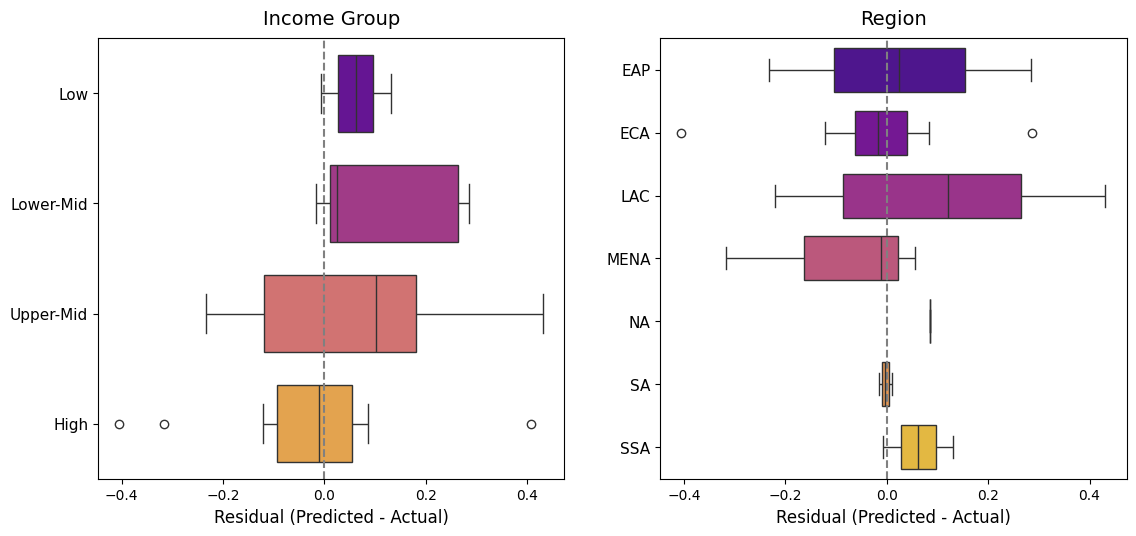

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", models["Extra Trees"])
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)


df_test = df_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
df_test['residual'] = y_pred - y_test

region_abbr = {
    "East Asia & Pacific": "EAP",
    "Europe & Central Asia": "ECA",
    "Latin America & Caribbean": "LAC",
    "Middle East & North Africa": "MENA",
    "North America": "NA",
    "South Asia": "SA",
    "Sub-Saharan Africa": "SSA"
}

income_abbr = {
    "Low income": "Low",
    "Lower middle income": "Lower-Mid",
    "Upper middle income": "Upper-Mid",
    "High income": "High"
}

df_plot = df_test.copy()
df_plot['Region_abbr'] = df_plot['Region'].map(region_abbr)
df_plot['Income_abbr'] = df_plot['Income_group'].map(income_abbr)

income_order = ["Low", "Lower-Mid", "Upper-Mid", "High"]
region_order = ["EAP", "ECA", "LAC", "MENA", "NA", "SA", "SSA"]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='residual', y='Income_abbr', data=df_plot,
            order=income_order,
            palette="plasma",
            orient='h',
            width=0.7)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Income Group", fontsize=14, pad=10, fontweight='normal')
plt.xlabel("Residual (Predicted - Actual)", fontsize=12)
plt.ylabel("")
plt.yticks(fontsize=11)

plt.subplot(1, 2, 2)
sns.boxplot(x='residual', y='Region_abbr', data=df_plot,
            order=region_order,
            palette="plasma",
            orient='h',
            width=0.7)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Region", fontsize=14, pad=10, fontweight='normal')
plt.xlabel("Residual (Predicted - Actual)", fontsize=12)
plt.ylabel("")
plt.yticks(fontsize=11)
plt.tight_layout(pad=3.0)
plt.show()

### 7.6 Feature Importance

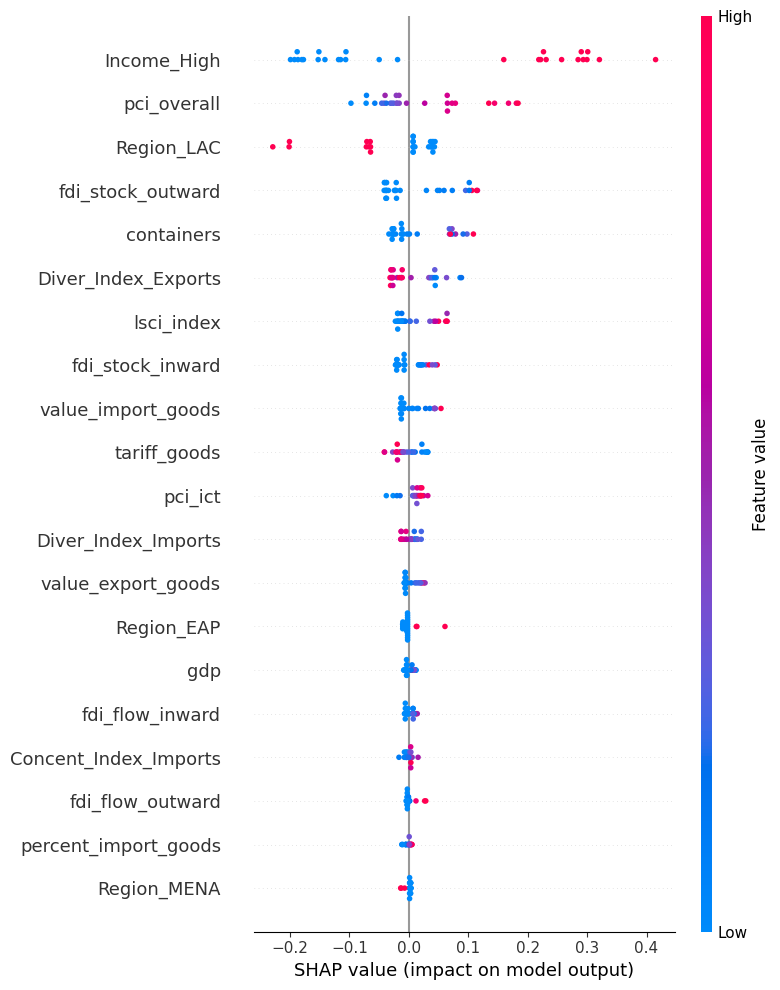

In [32]:
final_model = models["Extra Trees"]
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", final_model)
])
pipe.fit(X_train, y_train)

preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_feature_names)

region_abbr = {
    "East Asia & Pacific": "EAP",
    "Europe & Central Asia": "ECA",
    "Latin America & Caribbean": "LAC",
    "Middle East & North Africa": "MENA",
    "North America": "NA",
    "South Asia": "SA",
    "Sub-Saharan Africa": "SSA"
}

income_abbr = {
    "Low income": "Low",
    "Lower middle income": "Lower-Mid",
    "Upper middle income": "Upper-Mid",
    "High income": "High"
}

def shorten_label(label):
    if "Region_" in label:
        region = label.replace("Region_", "").strip()
        return f"Region_{region_abbr.get(region, region)}"
    elif "Income_group_" in label:
        income = label.replace("Income_group_", "").strip()
        return f"Income_{income_abbr.get(income, income)}"
    else:
        return label

feature_names_abbr = [shorten_label(f) for f in feature_names]

final_model.fit(X_train_transformed, y_train)

explainer = shap.Explainer(final_model, X_train_transformed)
shap_values = explainer(X_test_transformed)

shap.summary_plot(
    shap_values,
    features=X_test_transformed,
    feature_names=feature_names_abbr,
    max_display=20,
    plot_size=(8, 10),
    show=True
)


### **7. Predictions in y_test**

In [33]:
extra_trees_model = models["Extra Trees"]
pipe_et = Pipeline([
    ("preprocessor", preprocessor),
    ("model", extra_trees_model)
])
pipe_et.fit(X_train, y_train)

y_pred = pipe_et.predict(X_test)

results_table = pd.DataFrame({
    'Economy Label': df_test['Economy Label'],
    'Actual LPI': y_test,
    'Predicted LPI': y_pred
})

results_table_sorted = results_table.sort_values('Economy Label').reset_index(drop=True)

results_table_sorted

,Economy Label,Actual LPI,Predicted LPI
0,Antigua and Barbuda,2.9,2.806932
1,Bangladesh,2.6,2.583848
2,Belarus,2.7,2.784154
3,Brazil,3.2,3.114699
4,Chile,3.0,3.081494
5,China,3.7,3.467058
6,Costa Rica,2.9,2.680466
7,Denmark,4.1,3.695232
8,Fiji,2.3,2.583963
9,Grenada,2.5,2.647369


### **7. Predictions in new countries**

In [41]:
best_model = ExtraTreesRegressor(
    random_state=42,
    max_depth=4,
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=300
)

target = 'lpi_index'
numeric_features = [col for col in df_merged_lpi.columns if col not in ['Economy Label', 'Year', 'Region', 'Income_group', 'lpi_index']]
categorical_features = ['Region', 'Income_group']
features = numeric_features + categorical_features

X_full = df_merged_lpi[features]
y_full = df_merged_lpi[target]

numeric_transformer = Pipeline([
    ("imputer", IterativeImputer(estimator=RandomForestRegressor(random_state=42), max_iter=10, random_state=42)),
    ("scaler", RobustScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", best_model)
])
final_pipeline.fit(X_full, y_full)

X_to_predict = df_to_predict[features]
predicted_lpi = final_pipeline.predict(X_to_predict)

final_predictions = pd.DataFrame({
    'Economy Label': df_to_predict['Economy Label'],
    'Predicted LPI': predicted_lpi
}).sort_values('Economy Label').reset_index(drop=True)

final_predictions

,Economy Label,Predicted LPI
0,Azerbaijan,2.693947
1,Barbados,2.921370
2,Belize,2.607663
3,Ecuador,2.639773
4,Jordan,2.610796
5,Kenya,2.530960
6,Lebanon,2.688770
7,Morocco,2.821021
8,Mozambique,2.435015
9,Pakistan,2.566390
